In [1]:
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
from numpy import arange
import numpy as np
import re

# prepare file
table_file_name = 'latex_tables_from_all_operations.txt'
table_file = open(table_file_name, 'w')
table_file.write('')

test_file_name = 'rank.txt'
test_file = open(test_file_name, 'w')
table_file.write('')

def write(text):
    global test_file
    test_file.write(text)

In [2]:
rename_map = {
    "prisma": "Prisma",
    "sequelize": "Sequelize",
    "typeorm": "TypeORM",
    "postgres": "PostgreSQL",
    "mysql": "MySQL",
    "mssql": "MSSQL",
}

table_name_map = {
    "create-customer-bulk-100000": "Create - Bulk Customer Insertion - 100K",
    "create-customer-bulk-1000000": "Create - Bulk Customer Insertion - 1M",
    "create-customer-bulk-500000": "Create - Bulk Customer Insertion - 500K",
    
    "create-customer-with-address-100000": "Create - Customer \& Address Creation - 100K",
    "create-customer-with-address-1000000": "Create - Customer \& Address Creation - 1M",
    "create-customer-with-address-500000": "Create - Customer \& Address Creation - 500K",
    
    "create-order-100000": "Create - Order Creation - 100K",
    "create-order-1000000": "Create - Order Creation - 1M",
    "create-order-500000": "Create - Order Creation - 500K",
    
    "create-product-100000": "Create - Product Creation - 100K",
    "create-product-1000000": "Create - Product Creation - 1M",
    "create-product-500000": "Create - Product Creation - 500K",
    
    "delete-customer-100000": "Delete - Customer Deletion - 100K",
    "delete-customer-1000000": "Delete - Customer Deletion - 1M",
    "delete-customer-500000": "Delete - Customer Deletion - 500K",
    
    "delete-order-100000": "Delete - Order Deletion - 100K",
    "delete-order-1000000": "Delete - Order Deletion - 1M",
    "delete-order-500000": "Delete - Order Deletion - 500K",
    
    "read-customer-orders-100000": "Read - Customer Orders Retrieval - 100K",
    "read-customer-orders-1000000": "Read - Customer Orders Retrieval - 1M",
    "read-customer-orders-500000": "Read - Customer Orders Retrieval - 500K",
    
    "read-customer-products-100000": "Read - Customer Products Retrieval - 100K",
    "read-customer-products-1000000": "Read - Customer Products Retrieval - 1M",
    "read-customer-products-500000": "Read - Customer Products Retrieval - 500K",
    
    "read-product-100000": "Read - Product Retrieval - 100K",
    "read-product-1000000": "Read - Product Retrieval - 1M",
    "read-product-500000": "Read - Product Retrieval - 500K",
    
    "read-products-from-category-100000": "Read - Category-Based Product Retrieval - 100K",
    "read-products-from-category-1000000": "Read - Category-Based Product Retrieval - 1M",
    "read-products-from-category-500000": "Read - Category-Based Product Retrieval - 500K",
    
    "update-customer-phone-number-100000": "Update - Customer Phone Update - 100K",
    "update-customer-phone-number-1000000": "Update - Customer Phone Update - 1M",
    "update-customer-phone-number-500000": "Update - Customer Phone Update - 500K",
    
    "update-product-category-name-100000": "Update - Category Name Update - 100K",
    "update-product-category-name-1000000": "Update - Category Name Update - 1M",
    "update-product-category-name-500000": "Update - Category Name Update - 500K"
}


colorsMap = {
    "prisma": "blue",
    "typeorm": "red",
    "sequelize": "black"
}

rank_map = {
    100000: {},
    500000: {},
    1000000: {}
}

crud_all_sizes_rank_map = { }

crud_100K_rank_map = {}

curd_method_to_100K_rank_map = {
    "create": {},
    "read": {},
    "update": {},
    "delete": {}
}

rank_per_method_map = {}
rank_per_method_df = None

rank_df = None


def plot_datasets(title, df1: pd.DataFrame, df2: pd.DataFrame, df3: pd.DataFrame):
    # create plot titles
    title_1 = df1.columns[0].split(" - ")[0]
    title_2 = df2.columns[0].split(" - ")[0]
    title_3 = df3.columns[0].split(" - ")[0]
    # create database labels
    db_1 = df3.columns[0].split(" - ")[1]
    db_2 = df3.columns[1].split(" - ")[1]
    db_3 = df3.columns[2].split(" - ")[1]

    title_1 = rename_map[title_1]
    title_2 = rename_map[title_2]
    title_3 = rename_map[title_3]

    db_1 = rename_map[db_1]
    db_2 = rename_map[db_2]
    db_3 = rename_map[db_3]

    # Create a figure with 3 subplots

    # max = df1.values.max()
    # if df2.values.max() > max:
    #     max = df2.values.max()
    # if df3.values.max() > max:
    #     max = df3.values.max()

    fontsize = 18

    fig, axs = plt.subplots(1, 3, figsize=(18,5))
    # fig, axs = plt.subplots(1, 3, figsize=(15,5), subplot_kw={'ylim': (0, max)})

    # fig.suptitle(title, fontsize=16)

    plt.rcParams['xtick.labelsize'] = fontsize
    plt.rcParams['ytick.labelsize'] = fontsize

    # range = np.arange(min([df1.values, df2.values, df3.values]), max([df1.values, df2.values, df3.values])+1, 10)

    # Plot the first DataFrame on the first subplot
    axs[0].plot(df1.index, df1.values)
    axs[0].set_title(title_1, fontsize=fontsize)
    axs[0].set_ylabel("Speed in ms.", fontsize=fontsize)
    axs[0].hlines(xmin=0, xmax=len(df1.values), y=np.nanmean(df1), color='k', label='Mean')

    # axs[0].axhline( y=np.nanmean(df1), color='k', linestyle='-', label="mean")
    # axs[0].set_xticks(range)

    # Plot the second DataFrame on the second subplot
    axs[1].plot(df2.index, df2.values)
    axs[1].set_title(title_2, fontsize=fontsize)
    axs[1].set_xlabel("Iteration", fontsize=fontsize)
    axs[1].hlines(xmin=0, xmax=len(df2.values), y=np.nanmean(df2), color='k', label='mean')
    # axs[1].set_xticks(range)

    # Plot the third DataFrame on the third subplot
    axs[2].plot(df3.index, df3.values)
    axs[2].set_title(title_3, fontsize=fontsize)
    axs[2].hlines(xmin=0, xmax=len(df3.values), y=np.nanmean(df3), color='k', label='mean')
    axs[2].legend([db_1, db_2, db_3, "mean"], fontsize=fontsize, bbox_to_anchor=(1, 1))

    # axs[2].axhline(y=np.nanmean(df3), color='k', linestyle='-', label='mean')
    # axs[2].set_xticks(range)

    # Adjust spacing between subplots
    plt.tight_layout()
    # Show the plot
    plt.show()



class CustomDataset:
    dir = "" # e.g. C:\workspace\orm\orm-client\result\create\create-customer-with-address-100
    path = "" # e.g. C:\workspace\orm\orm-client\result\create\create-customer-with-address-100\prisma.postgres.2023-03-21T11-47-30.csv
    csv_file_name = "" # e.g. prisma.postgres.2023-03-21T11-47-30.csv
    framework = "" # prisma | typeorm | sequelize
    db = "" # postgres | mysql | mssql
    method = "" # create | read | update | delete
    test_name = "" # e.g. create-customer-with-address-100
    test_name_without_number = "" # e.g. create-customer-with-address
    df = None
    describe = None
    describeDf = None
    color = None
    tuples = 0

    def __init__(self, path, method, test_name, csv_file_name):
        self.dir = os.path.dirname(path)
        self.path = path
        self.method = method
        self.test_name = test_name
        self.test_name_without_number = re.sub(r'\d', '', test_name)
        self.csv_file_name = csv_file_name
        self.framework = csv_file_name.split(".")[0]
        self.db = csv_file_name.split(".")[1]
        self.df = read_csv(path, sep=";")
        self.color = colorsMap[self.framework]
        self.tuples = int(self.test_name.split("-")[-1])
        

    def create_describe(self):
        # create describe for time column
        self.describe = self.df["time"].describe()
        # create csv with describe values
        self.describe.to_csv(self.dir + "/" + self.csv_file_name + ".describe.csv", float_format="%.2f")
        # convert describe indexes to columns and create new dataframe
        self.describeDf = pd.DataFrame([self.describe[self.describe.index.values]], columns=self.describe.index.values, index=[self.get_framework_db_string()])

    def get_framework_db_string(self):
        return self.framework + " - " + self.db 








def summarize_custom_datasets_mean_values(custom_datasets: list[CustomDataset]):
    # Group CustomDatasets by framework and db
    group_dict: dict[str, list[CustomDataset]] = {}

    for dataset in custom_datasets:
        key = dataset.framework + "-" + dataset.db
        if key not in group_dict:
            group_dict[key] = []
        group_dict[key].append(dataset)

    means = {}

    # Calculate the mean value for each group and print the results
    for key, group in group_dict.items():
        mean_value = 0
        length = 0

        for custom_dataset in group:
            if 'mean' in custom_dataset.describe:
                mean_value += custom_dataset.describe["mean"]
                length += 1

        means[key] = mean_value / length







class CustomerConverter:
    custom_datasets: list[CustomDataset] = []
    custom_ds_map: dict[str, list[CustomDataset]] = {}
    grouped_custom_ds_map: dict[str, list[CustomDataset]]= {}
    groups_map = {}

    def convert(self, path):
        for file_path in glob.iglob(path + "/**/*.csv", recursive=True):
            if (file_path.find("describe") != -1):
                continue
            [result_dir, method, test_name, csv_file_name] = file_path.split("\\")
            dataset = CustomDataset(file_path,method,test_name,csv_file_name)
            self.custom_datasets.append(dataset)
        self.create_describe()
        self.group_datasets()

    def create_describe(self):
        for dataset in self.custom_datasets:
            dataset.create_describe()

    def group_datasets(self):
        for custom_dataset in self.custom_datasets:
            if custom_dataset.test_name not in self.custom_ds_map:
                self.custom_ds_map[custom_dataset.test_name] = []
            if custom_dataset.test_name + "-" + custom_dataset.framework not in self.grouped_custom_ds_map:
                self.grouped_custom_ds_map[custom_dataset.test_name + "-" + custom_dataset.framework] = []
            self.grouped_custom_ds_map[custom_dataset.test_name + "-" + custom_dataset.framework].append(custom_dataset)
            self.custom_ds_map[custom_dataset.test_name].append(custom_dataset)


    def merge_df_for_same_operations(self):
        map = {}
        for dataset in self.custom_datasets:
            if dataset.test_name_without_number not in self.custom_ds_map:
                key = dataset.test_name_without_number
                map[key] = {}
                map[key][dataset.tuples] = dataset.describeDf['50%']
        return map    


    def create_describe_for_groups(self):
        for key, datasets in self.custom_ds_map.items():
            df = None
            tuples = 0
            method = None

            for dataset in datasets:
                if df is None:
                    df = dataset.describeDf
                else:
                    df = df.append(dataset.describeDf)
                tuples = dataset.tuples
                method = dataset.method

            df.reset_index(inplace=True)
            df.rename(columns={'index': 'framework - db'}, inplace=True)
            df.reset_index()


            df = df.sort_values(by="50%", ascending=True)
            df['rank'] = df.reset_index().index + 1

                


            # Split 'framework - db' into 'framework' and 'db'
            df[['framework', 'db']] = df['framework - db'].str.split(' - ', expand=True)

            # df['size'] = int(key.split('-')[-1]) / 1000000

            # Drop the original 'framework - db' column
            df.drop(columns=['framework - db'], inplace=True)

            # Reorder columns to match desired output
            # df = df[['framework', 'db', 'size', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'rank']]
            df = df[['framework', 'db', 'count', 'mean', 'std', 'min', '50%', 'max', 'rank']]

            df = df.replace(rename_map)
            

            # create combinations ranks for all methods and db sizes
            global crud_all_sizes_rank_map
            for index, row in df.iterrows():
                k = row.framework + ' ' + row.db
                if k in crud_all_sizes_rank_map:
                    crud_all_sizes_rank_map[k][row['rank']] += 1
                else:
                    crud_all_sizes_rank_map[k] = { 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8:0, 9:0}
                    crud_all_sizes_rank_map[k][row['rank']] = 1

            global curd_method_to_100K_rank_map
            global crud_100K_rank_map

            if tuples == 100000:
                # create total rank stats for 100k
                for index, row in df.iterrows():
                    k = row.framework + ' ' + row.db
                    if k in crud_100K_rank_map:
                        crud_100K_rank_map[k][row['rank']] += 1
                    else:
                        crud_100K_rank_map[k] = { 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8:0, 9:0}
                        crud_100K_rank_map[k][row['rank']] = 1
                        
                # create rank stats for each method for 100k
                for index, row in df.iterrows():
                    k = row.framework + ' ' + row.db
                    if k in curd_method_to_100K_rank_map[method]:
                        curd_method_to_100K_rank_map[method][k][row['rank']] += 1  
                    else:
                        curd_method_to_100K_rank_map[method][k] = { 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8:0, 9:0}
                        curd_method_to_100K_rank_map[method][k][row['rank']] = 1




            # create rank map
            global rank_map
            if tuples not in rank_map:
                rank_map[tuples] = {}

            for index, row in df.iterrows():
                if "bulk" not in key:
                    k = row.framework + ' ' + row.db
                    if k in rank_map[tuples]:
                        rank_map[tuples][k] = rank_map[tuples][k] + row['50%']
                    else:
                        rank_map[tuples][k] = row['50%']

            # create rank per method map
            global rank_per_method_map
            if method not in rank_per_method_map:
                rank_per_method_map[method] = {}
            
            if tuples not in rank_per_method_map[method]:
                rank_per_method_map[method][tuples] = {}

            for index, row in df.iterrows():
                if "bulk" not in key:
                    k = row.framework + ' ' + row.db
                    if k in rank_per_method_map[method][tuples]:
                        rank_per_method_map[method][tuples][k] = rank_per_method_map[method][tuples][k] + row['50%']
                    else:
                        rank_per_method_map[method][tuples][k] = row['50%']

            df.rename(columns={'framework': 'Framework'}, inplace=True)
            df.rename(columns={'db': 'DB'}, inplace=True)
            # create csv and print out latext table
            df.to_csv(datasets[0].dir +"/merged.describe.csv", float_format="%.2f")
            self.groups_map[key] = df
            format = "l" + "@{\hskip 12pt}" + 4 * "S[table-format = 2.2]"
            file = open('latex_tables_from_all_operations.txt', 'a')
            latex_tables = df.to_latex(index=False,position='h', float_format=lambda x: '%10.1f' % x, caption=table_name_map[key], label='tab:' + key)
            file.write(latex_tables)
            file.write("\n" * 4)
            file.close()
            


    def create_charts(self):

        # for test_name, datasets in self.test_name_to_datasets.items():
        #     test_name_to_times = {}
        #     colors = []
        #     for dataset in datasets:
        #         test_name_to_times[dataset.get_framework_db_string()] = dataset.df["time"]
        #         colors.append(dataset.color)
        #     df = pd.DataFrame(test_name_to_times)
        #     dfs.append(df)
        #     df.plot(fontsize=12,title=test_name, xticks=np.arange(min(df.index), max(df.index), 100), xlabel="number of test executions", ylabel="time in ms", figsize=(24,16))

        test_map: dict[str, list[CustomDataset]] = {}

        for key, custom_dataset in self.grouped_custom_ds_map.items():
            time_df_map = {}

            for dataset in custom_dataset:
                time_df_map[dataset.get_framework_db_string()] = dataset.df["time"]
            
            df = pd.DataFrame(time_df_map)

            test_name = custom_dataset[0].test_name
            if test_name not in test_map:
                test_map[test_name] = []
            test_map[test_name].append(df)
            # df.plot(fontsize=12,title=key, xticks=np.arange(min(df.index), max(df.index), 100), xlabel="number of test executions", ylabel="time in ms", figsize=(24,16))


        for test_name, dfs in test_map.items():
            if len(dfs) == 3:
                plot_datasets(test_name, dfs[0], dfs[1], dfs[2])




    def create_mean(self):
        summarize_custom_datasets_mean_values(self.custom_datasets)


# Tables

In [3]:
converter = CustomerConverter()
converter.convert("C:/workspace/orm/orm-client/result")
converter.create_describe_for_groups()
converter.create_mean()

<ipython-input-2-3a6db2af69d5>:287: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataset.describeDf)
<ipython-input-2-3a6db2af69d5>:287: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataset.describeDf)
<ipython-input-2-3a6db2af69d5>:287: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataset.describeDf)
<ipython-input-2-3a6db2af69d5>:287: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataset.describeDf)
<ipython-input-2-3a6db2af69d5>:287: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = 

## Create Ranks over all Tests for each framework-db combination

In [4]:
def create_combi_rank(map):
    df = pd.DataFrame(map)
    df_t = df.transpose().reset_index()
    new_columns = ['Compination'] + list(range(1, 10))
    df_t.columns = new_columns
    for i in range(1, 10):
        df_t = df_t.sort_values(by=[10 - i], ascending=False)
    
    df_t[["Framework", "DB"]] = df_t.Compination.str.split(" ", expand=True)
    df_t.drop(columns=['Compination'], axis=1, inplace=True)
    df_t = df_t[['Framework', 'DB', 1, 2, 3, 4, 5, 6, 7, 8, 9]]
    return df_t


def combi_rank_to_latex(df, operation):
    # caption = 'Evaluating the Impact of Database and Framework Pairings on ' + operation.capitalize() + ' Operations for Different Database Sizes.'
    caption = 'Ranking of ' + operation.capitalize() + ' Operations at 100K DB Size'
    label = "tab:" + operation.lower() + "-ranking"
    print(df.to_latex(index=False,position='h', float_format=lambda x: '%10.0f' % x, caption=caption, label=label))

In [5]:
create_method_rank_df = create_combi_rank(curd_method_to_100K_rank_map['create'])
create_method_rank_df

,Framework,DB,1,2,3,4,5,6,7,8,9
1,TypeORM,PostgreSQL,2,2,0,0,0,0,0,0,0
2,Sequelize,PostgreSQL,1,1,2,0,0,0,0,0,0
0,Sequelize,MySQL,1,0,0,1,0,1,1,0,0
3,Prisma,PostgreSQL,0,1,1,1,0,0,0,1,0
5,Prisma,MySQL,0,0,1,0,1,2,0,0,0
4,TypeORM,MySQL,0,0,0,2,1,0,1,0,0
8,Sequelize,MSSQL,0,0,0,0,2,0,0,1,1
7,Prisma,MSSQL,0,0,0,0,0,1,0,2,1
6,TypeORM,MSSQL,0,0,0,0,0,0,2,0,2


In [6]:
combi_rank_to_latex(create_method_rank_df, 'create')

\begin{table}[h]
\centering
\caption{Ranking of Create Operations at 100K DB Size}
\label{tab:create-ranking}
\begin{tabular}{llrrrrrrrrr}
\toprule
Framework &         DB &  1 &  2 &  3 &  4 &  5 &  6 &  7 &  8 &  9 \\
\midrule
  TypeORM & PostgreSQL &  2 &  2 &  0 &  0 &  0 &  0 &  0 &  0 &  0 \\
Sequelize & PostgreSQL &  1 &  1 &  2 &  0 &  0 &  0 &  0 &  0 &  0 \\
Sequelize &      MySQL &  1 &  0 &  0 &  1 &  0 &  1 &  1 &  0 &  0 \\
   Prisma & PostgreSQL &  0 &  1 &  1 &  1 &  0 &  0 &  0 &  1 &  0 \\
   Prisma &      MySQL &  0 &  0 &  1 &  0 &  1 &  2 &  0 &  0 &  0 \\
  TypeORM &      MySQL &  0 &  0 &  0 &  2 &  1 &  0 &  1 &  0 &  0 \\
Sequelize &      MSSQL &  0 &  0 &  0 &  0 &  2 &  0 &  0 &  1 &  1 \\
   Prisma &      MSSQL &  0 &  0 &  0 &  0 &  0 &  1 &  0 &  2 &  1 \\
  TypeORM &      MSSQL &  0 &  0 &  0 &  0 &  0 &  0 &  2 &  0 &  2 \\
\bottomrule
\end{tabular}
\end{table}



<ipython-input-4-27f53e939581>:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False,position='h', float_format=lambda x: '%10.0f' % x, caption=caption, label=label))


In [7]:
read_method_rank_df = create_combi_rank(curd_method_to_100K_rank_map['read'])
read_method_rank_df

,Framework,DB,1,2,3,4,5,6,7,8,9
0,Sequelize,MySQL,2,0,0,1,0,0,0,0,1
2,TypeORM,MySQL,1,0,3,0,0,0,0,0,0
8,TypeORM,PostgreSQL,1,0,0,1,0,0,1,0,1
1,Prisma,MySQL,0,3,0,0,0,1,0,0,0
5,Sequelize,PostgreSQL,0,1,1,1,0,1,0,0,0
3,Prisma,MSSQL,0,0,0,1,0,1,1,1,0
6,Prisma,PostgreSQL,0,0,0,0,3,0,1,0,0
4,TypeORM,MSSQL,0,0,0,0,1,0,1,0,2
7,Sequelize,MSSQL,0,0,0,0,0,1,0,3,0


In [8]:
update_method_rank_df = create_combi_rank(curd_method_to_100K_rank_map['update'])
update_method_rank_df

,Framework,DB,1,2,3,4,5,6,7,8,9
0,Sequelize,PostgreSQL,1,0,0,1,0,0,0,0,0
3,TypeORM,MySQL,1,0,0,1,0,0,0,0,0
1,TypeORM,PostgreSQL,0,1,0,0,1,0,0,0,0
7,Sequelize,MySQL,0,1,0,0,0,0,0,1,0
4,Prisma,MySQL,0,0,1,0,1,0,0,0,0
2,Prisma,PostgreSQL,0,0,1,0,0,1,0,0,0
5,Sequelize,MSSQL,0,0,0,0,0,1,1,0,0
6,Prisma,MSSQL,0,0,0,0,0,0,1,1,0
8,TypeORM,MSSQL,0,0,0,0,0,0,0,0,2


In [9]:
delete_method_rank_df = create_combi_rank(curd_method_to_100K_rank_map['delete'])
delete_method_rank_df

,Framework,DB,1,2,3,4,5,6,7,8,9
0,TypeORM,MySQL,2,0,0,0,0,0,0,0,0
1,Sequelize,MySQL,0,2,0,0,0,0,0,0,0
2,Prisma,MySQL,0,0,2,0,0,0,0,0,0
3,TypeORM,PostgreSQL,0,0,0,2,0,0,0,0,0
4,Prisma,PostgreSQL,0,0,0,0,1,1,0,0,0
7,Sequelize,PostgreSQL,0,0,0,0,1,0,0,1,0
5,Prisma,MSSQL,0,0,0,0,0,1,0,1,0
6,TypeORM,MSSQL,0,0,0,0,0,0,2,0,0
8,Sequelize,MSSQL,0,0,0,0,0,0,0,0,2


In [10]:
crud_100K_rank_df = create_combi_rank(crud_100K_rank_map)
crud_100K_rank_df

,Framework,DB,1,2,3,4,5,6,7,8,9
4,TypeORM,MySQL,4,0,3,3,1,0,1,0,0
1,TypeORM,PostgreSQL,3,3,0,3,1,0,1,0,1
0,Sequelize,MySQL,3,3,0,2,0,1,1,1,1
2,Sequelize,PostgreSQL,2,2,3,2,1,1,0,1,0
5,Prisma,MySQL,0,3,4,0,2,3,0,0,0
3,Prisma,PostgreSQL,0,1,2,1,4,2,1,1,0
7,Prisma,MSSQL,0,0,0,1,0,3,2,5,1
8,Sequelize,MSSQL,0,0,0,0,2,2,1,4,3
6,TypeORM,MSSQL,0,0,0,0,1,0,5,0,6


In [11]:
combination_df = create_combi_rank(crud_all_sizes_rank_map)
combination_df

,Framework,DB,1,2,3,4,5,6,7,8,9
1,TypeORM,PostgreSQL,11,9,0,7,4,1,1,0,3
4,TypeORM,MySQL,10,2,7,12,2,0,1,2,0
0,Sequelize,MySQL,9,9,0,4,0,5,3,3,3
2,Sequelize,PostgreSQL,4,8,9,6,5,1,0,3,0
5,Prisma,MySQL,2,6,13,1,8,6,0,0,0
3,Prisma,PostgreSQL,0,2,7,5,9,7,3,3,0
7,Prisma,MSSQL,0,0,0,1,2,8,10,12,3
8,Sequelize,MSSQL,0,0,0,0,5,3,7,12,9
6,TypeORM,MSSQL,0,0,0,0,1,5,11,1,18


## Create Tables

In [12]:
def add_make_box_to_tables():
    input_path = table_file_name
    output_path = input_path
    
    with open(input_path, 'r') as file:
        lines = file.readlines()
    
    with open(output_path, 'w') as file:
        inside_tabular = False
        for line in lines:
            if "\\begin{tabular}" in line:
                file.write("\\makebox[\\linewidth][c]{\n")
                inside_tabular = True
            if "\\end{tabular}" in line:
                line = "\\end{tabular}\n}\n"
                inside_tabular = False
            file.write(line)


add_make_box_to_tables()

O

In [13]:
def create_ranking_table(df):
    df.columns = df.columns.astype(str)
    df['SUM'] = df.sum(axis=1)
    df.sort_values(by=['SUM'], ascending=True, inplace=True)
    df = df.reset_index()
    df.rename(columns={'index':'Combination'}, inplace=True)
    df['Rank'] = df.reset_index().index + 1
    df[["Framework", "DB"]] = df.Combination.str.split(" ", expand=True)
    df.drop(columns=['Combination'], axis=1, inplace=True)
    df = df[['Framework', 'DB', '100000', '500000', '1000000', 'SUM', 'Rank']]
    df.rename(columns={'100000':'100K', '500000': '500K', '1000000': '1M','SUM': 'Sum of Medians'}, inplace=True)
    return df

def ranking_table_to_latex(df, operation):
    # caption = 'Evaluating the Impact of Database and Framework Pairings on ' + operation.capitalize() + ' Operations for Different Database Sizes.'
    caption = 'Scale Effect of ' + operation.capitalize() + ' Operations across Database Sizes'
    label = "tab:" + operation.lower() + "-scale-effect"
    print(df.to_latex(index=False,position='h', float_format=lambda x: '%10.1f' % x, caption=caption, label=label))

In [14]:
columns = ["100K", "500K", "1M", "Sum of Medians"]

# Total statistics

In [15]:
def d(df, num):
    df[columns] = round(df[columns] / num, 1)
    df['Sum of Medians'] = round(df["Sum of Medians"] / 3, 1)
    return df

In [16]:
total_rank_df = pd.DataFrame(rank_map)
total_rank_df = create_ranking_table(total_rank_df)
d(total_rank_df, 11)

,Framework,DB,100K,500K,1M,Sum of Medians,Rank
0,Prisma,MySQL,4.7,4.8,4.9,4.8,1
1,Sequelize,PostgreSQL,10.0,30.6,57.4,32.7,2
2,Prisma,PostgreSQL,11.2,34.4,63.3,36.3,3
3,TypeORM,PostgreSQL,10.9,34.0,65.8,36.9,4
4,TypeORM,MySQL,4.2,46.2,94.8,48.4,5
5,Prisma,MSSQL,15.5,47.4,89.3,50.7,6
6,TypeORM,MSSQL,18.0,52.0,94.6,54.9,7
7,Sequelize,MSSQL,16.8,52.7,97.5,55.7,8
8,Sequelize,MySQL,15.9,64.2,132.7,71.0,9


In [17]:
ranking_table_to_latex(total_rank_df, "CRUD")

\begin{table}[h]
\centering
\caption{Scale Effect of Crud Operations across Database Sizes}
\label{tab:crud-scale-effect}
\begin{tabular}{llrrrrr}
\toprule
Framework &         DB &       100K &       500K &         1M &  Sum of Medians &  Rank \\
\midrule
   Prisma &      MySQL &        4.7 &        4.8 &        4.9 &             4.8 &     1 \\
Sequelize & PostgreSQL &       10.0 &       30.6 &       57.4 &            32.7 &     2 \\
   Prisma & PostgreSQL &       11.2 &       34.4 &       63.3 &            36.3 &     3 \\
  TypeORM & PostgreSQL &       10.9 &       34.0 &       65.8 &            36.9 &     4 \\
  TypeORM &      MySQL &        4.2 &       46.2 &       94.8 &            48.4 &     5 \\
   Prisma &      MSSQL &       15.5 &       47.4 &       89.3 &            50.7 &     6 \\
  TypeORM &      MSSQL &       18.0 &       52.0 &       94.6 &            54.9 &     7 \\
Sequelize &      MSSQL &       16.8 &       52.7 &       97.5 &            55.7 &     8 \\
Sequelize &     

<ipython-input-13-90659f911a93>:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False,position='h', float_format=lambda x: '%10.1f' % x, caption=caption, label=label))


# Create statistics

In [18]:
create_df = pd.DataFrame(rank_per_method_map['create'])
create_df = create_ranking_table(create_df)
d(create_df, 3)

,Framework,DB,100K,500K,1M,Sum of Medians,Rank
0,TypeORM,PostgreSQL,3.0,2.7,2.9,2.9,1
1,Sequelize,PostgreSQL,4.1,4.4,4.4,4.3,2
2,Prisma,MySQL,6.4,6.6,6.6,6.5,3
3,TypeORM,MySQL,6.6,6.7,6.9,6.7,4
4,Sequelize,MySQL,9.3,10.0,10.1,9.8,5
5,Sequelize,MSSQL,9.2,10.2,10.1,9.8,6
6,TypeORM,MSSQL,12.2,12.3,12.3,12.3,7
7,Prisma,PostgreSQL,7.9,16.5,27.2,17.2,8
8,Prisma,MSSQL,13.2,27.4,45.3,28.6,9


In [19]:
print(rank_per_method_map)

{'create': {100000: {'TypeORM PostgreSQL': 8.989999999999998, 'Prisma PostgreSQL': 23.8, 'Sequelize PostgreSQL': 12.280000000000001, 'TypeORM MySQL': 19.71, 'Prisma MySQL': 19.28, 'Prisma MSSQL': 39.504999999999995, 'Sequelize MySQL': 27.79, 'Sequelize MSSQL': 27.639999999999997, 'TypeORM MSSQL': 36.55500000000001}, 1000000: {'TypeORM PostgreSQL': 8.56, 'Sequelize PostgreSQL': 13.23, 'Prisma PostgreSQL': 81.72500000000001, 'TypeORM MySQL': 20.645000000000003, 'Prisma MySQL': 19.77, 'Prisma MSSQL': 136.01, 'Sequelize MySQL': 30.415000000000003, 'Sequelize MSSQL': 30.265, 'TypeORM MSSQL': 37.005}, 500000: {'TypeORM PostgreSQL': 8.24, 'Prisma PostgreSQL': 49.629999999999995, 'Sequelize PostgreSQL': 13.260000000000002, 'TypeORM MySQL': 20.14, 'Prisma MySQL': 19.700000000000003, 'Prisma MSSQL': 82.22, 'Sequelize MySQL': 30.029999999999998, 'Sequelize MSSQL': 30.585000000000004, 'TypeORM MSSQL': 37.025000000000006}}, 'delete': {100000: {'TypeORM MySQL': 8.81, 'Sequelize MySQL': 10.4400000000

In [20]:
ranking_table_to_latex(create_df, "create")

\begin{table}[h]
\centering
\caption{Scale Effect of Create Operations across Database Sizes}
\label{tab:create-scale-effect}
\begin{tabular}{llrrrrr}
\toprule
Framework &         DB &       100K &       500K &         1M &  Sum of Medians &  Rank \\
\midrule
  TypeORM & PostgreSQL &        3.0 &        2.7 &        2.9 &             2.9 &     1 \\
Sequelize & PostgreSQL &        4.1 &        4.4 &        4.4 &             4.3 &     2 \\
   Prisma &      MySQL &        6.4 &        6.6 &        6.6 &             6.5 &     3 \\
  TypeORM &      MySQL &        6.6 &        6.7 &        6.9 &             6.7 &     4 \\
Sequelize &      MySQL &        9.3 &       10.0 &       10.1 &             9.8 &     5 \\
Sequelize &      MSSQL &        9.2 &       10.2 &       10.1 &             9.8 &     6 \\
  TypeORM &      MSSQL &       12.2 &       12.3 &       12.3 &            12.3 &     7 \\
   Prisma & PostgreSQL &        7.9 &       16.5 &       27.2 &            17.2 &     8 \\
   Prisma & 

<ipython-input-13-90659f911a93>:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False,position='h', float_format=lambda x: '%10.1f' % x, caption=caption, label=label))


# Read statistics

In [21]:
read_df = pd.DataFrame(rank_per_method_map['read'])
read_df = create_ranking_table(read_df)
d(read_df, 4)

,Framework,DB,100K,500K,1M,Sum of Medians,Rank
0,Prisma,MySQL,3.2,3.4,3.4,3.3,1
1,Sequelize,PostgreSQL,14.6,40.9,77.3,44.3,2
2,Prisma,PostgreSQL,16.4,49.3,90.5,52.0,3
3,TypeORM,PostgreSQL,20.5,64.6,128.7,71.3,4
4,Prisma,MSSQL,18.8,71.1,139.1,76.3,5
5,Sequelize,MSSQL,20.9,81.8,156.1,86.3,6
6,TypeORM,MSSQL,25.3,94.0,176.8,98.7,7
7,TypeORM,MySQL,2.6,117.9,251.6,124.0,8
8,Sequelize,MySQL,31.6,164.2,352.4,182.7,9


In [22]:
ranking_table_to_latex(read_df, 'read')

\begin{table}[h]
\centering
\caption{Scale Effect of Read Operations across Database Sizes}
\label{tab:read-scale-effect}
\begin{tabular}{llrrrrr}
\toprule
Framework &         DB &       100K &       500K &         1M &  Sum of Medians &  Rank \\
\midrule
   Prisma &      MySQL &        3.2 &        3.4 &        3.4 &             3.3 &     1 \\
Sequelize & PostgreSQL &       14.6 &       40.9 &       77.3 &            44.3 &     2 \\
   Prisma & PostgreSQL &       16.4 &       49.3 &       90.5 &            52.0 &     3 \\
  TypeORM & PostgreSQL &       20.5 &       64.6 &      128.7 &            71.3 &     4 \\
   Prisma &      MSSQL &       18.8 &       71.1 &      139.1 &            76.3 &     5 \\
Sequelize &      MSSQL &       20.9 &       81.8 &      156.1 &            86.3 &     6 \\
  TypeORM &      MSSQL &       25.3 &       94.0 &      176.8 &            98.7 &     7 \\
  TypeORM &      MySQL &        2.6 &      117.9 &      251.6 &           124.0 &     8 \\
Sequelize &     

<ipython-input-13-90659f911a93>:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False,position='h', float_format=lambda x: '%10.1f' % x, caption=caption, label=label))


# Update

In [23]:
update_df = pd.DataFrame(rank_per_method_map['update'])
update_df = create_ranking_table(update_df)
d(update_df, 2)

,Framework,DB,100K,500K,1M,Sum of Medians,Rank
0,Sequelize,PostgreSQL,2.4,2.5,2.4,2.5,1
1,TypeORM,PostgreSQL,2.5,2.6,2.6,2.6,2
2,TypeORM,MySQL,3.5,3.5,3.5,3.5,3
3,Prisma,PostgreSQL,3.2,3.9,4.0,3.7,4
4,Prisma,MySQL,4.0,4.0,4.1,4.0,5
5,Sequelize,MySQL,4.9,4.6,4.7,4.7,6
6,Sequelize,MSSQL,5.7,5.6,5.6,5.7,7
7,Prisma,MSSQL,6.2,6.0,6.2,6.1,8
8,TypeORM,MSSQL,8.7,8.7,8.7,8.7,9


In [24]:
ranking_table_to_latex(update_df, 'update')

\begin{table}[h]
\centering
\caption{Scale Effect of Update Operations across Database Sizes}
\label{tab:update-scale-effect}
\begin{tabular}{llrrrrr}
\toprule
Framework &         DB &       100K &       500K &         1M &  Sum of Medians &  Rank \\
\midrule
Sequelize & PostgreSQL &        2.4 &        2.5 &        2.4 &             2.5 &     1 \\
  TypeORM & PostgreSQL &        2.5 &        2.6 &        2.6 &             2.6 &     2 \\
  TypeORM &      MySQL &        3.5 &        3.5 &        3.5 &             3.5 &     3 \\
   Prisma & PostgreSQL &        3.2 &        3.9 &        4.0 &             3.7 &     4 \\
   Prisma &      MySQL &        4.0 &        4.0 &        4.1 &             4.0 &     5 \\
Sequelize &      MySQL &        4.9 &        4.6 &        4.7 &             4.7 &     6 \\
Sequelize &      MSSQL &        5.7 &        5.6 &        5.6 &             5.7 &     7 \\
   Prisma &      MSSQL &        6.2 &        6.0 &        6.2 &             6.1 &     8 \\
  TypeORM & 

<ipython-input-13-90659f911a93>:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False,position='h', float_format=lambda x: '%10.1f' % x, caption=caption, label=label))


# Delete statistics

In [25]:
delete_df = pd.DataFrame(rank_per_method_map['delete'])
delete_df = create_ranking_table(delete_df)
d(delete_df, 2)

,Framework,DB,100K,500K,1M,Sum of Medians,Rank
0,TypeORM,MySQL,4.4,4.6,4.5,4.5,1
1,Sequelize,MySQL,5.2,5.3,5.4,5.3,2
2,Prisma,MySQL,5.9,6.1,6.2,6.0,3
3,TypeORM,PostgreSQL,11.7,51.1,97.6,53.4,4
4,Prisma,PostgreSQL,13.8,61.9,122.5,66.1,5
5,TypeORM,MSSQL,21.3,71.0,139.5,77.2,6
6,Prisma,MSSQL,21.5,71.4,139.0,77.3,7
7,Sequelize,PostgreSQL,17.2,77.5,151.9,82.2,8
8,Sequelize,MSSQL,30.9,105.2,203.5,113.2,9


In [26]:
ranking_table_to_latex(delete_df, 'delete')

\begin{table}[h]
\centering
\caption{Scale Effect of Delete Operations across Database Sizes}
\label{tab:delete-scale-effect}
\begin{tabular}{llrrrrr}
\toprule
Framework &         DB &       100K &       500K &         1M &  Sum of Medians &  Rank \\
\midrule
  TypeORM &      MySQL &        4.4 &        4.6 &        4.5 &             4.5 &     1 \\
Sequelize &      MySQL &        5.2 &        5.3 &        5.4 &             5.3 &     2 \\
   Prisma &      MySQL &        5.9 &        6.1 &        6.2 &             6.0 &     3 \\
  TypeORM & PostgreSQL &       11.7 &       51.1 &       97.6 &            53.4 &     4 \\
   Prisma & PostgreSQL &       13.8 &       61.9 &      122.5 &            66.1 &     5 \\
  TypeORM &      MSSQL &       21.3 &       71.0 &      139.5 &            77.2 &     6 \\
   Prisma &      MSSQL &       21.5 &       71.4 &      139.0 &            77.3 &     7 \\
Sequelize & PostgreSQL &       17.2 &       77.5 &      151.9 &            82.2 &     8 \\
Sequelize & 

<ipython-input-13-90659f911a93>:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False,position='h', float_format=lambda x: '%10.1f' % x, caption=caption, label=label))


# Grafs

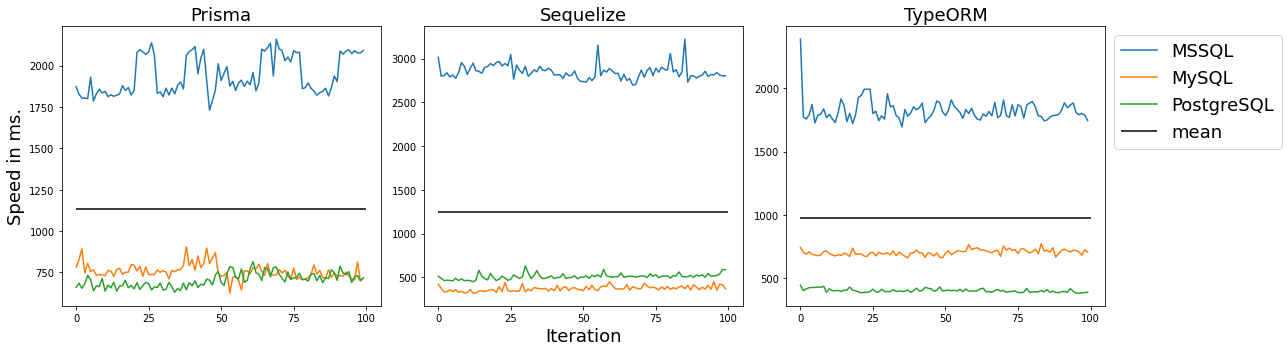

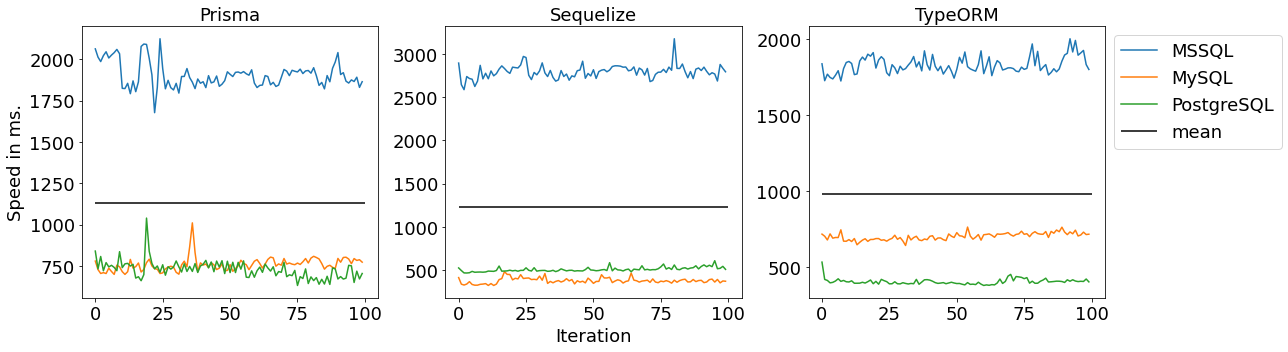

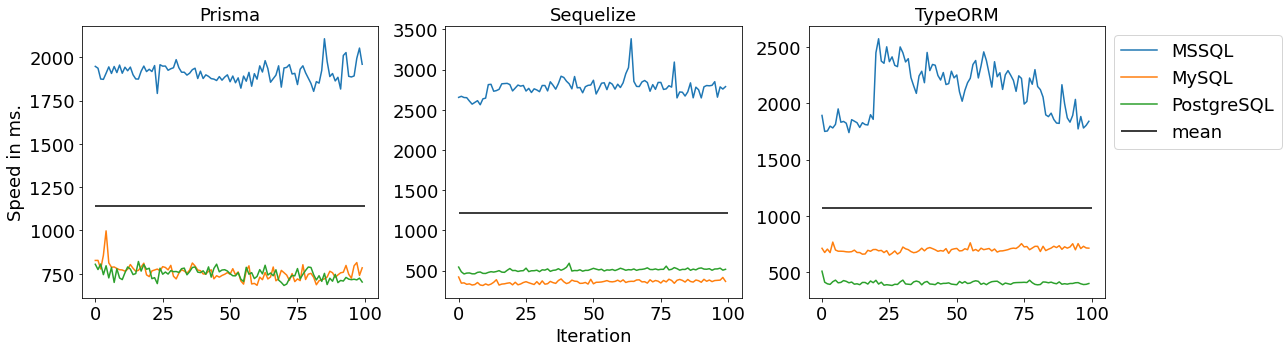

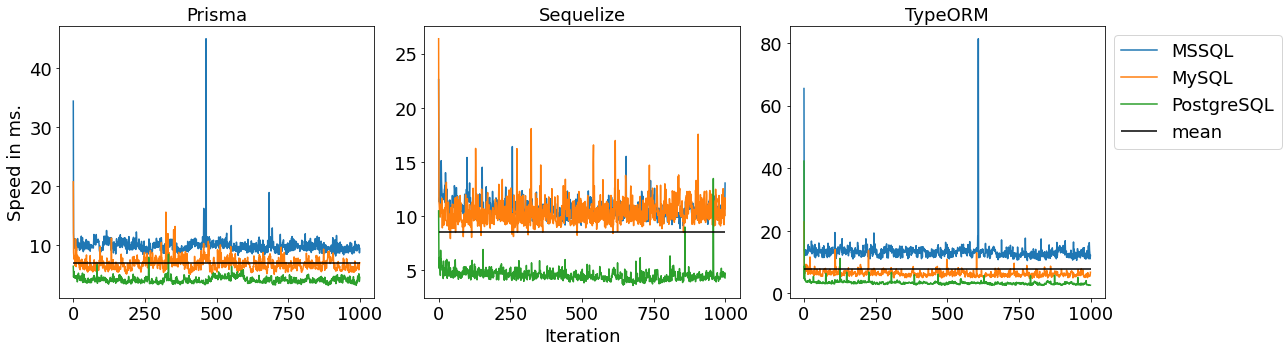

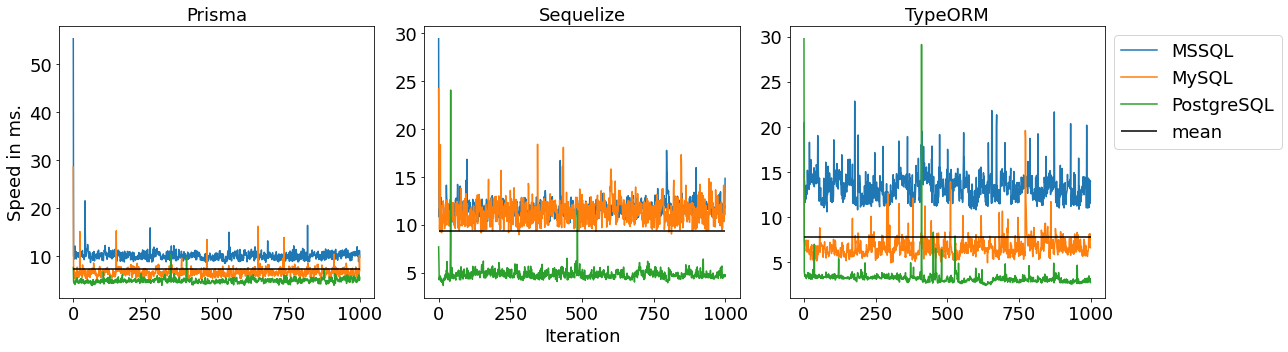

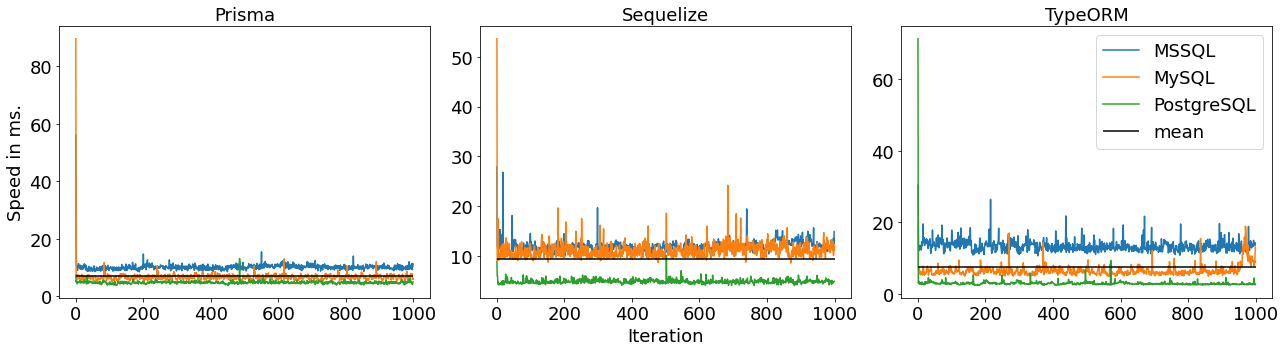

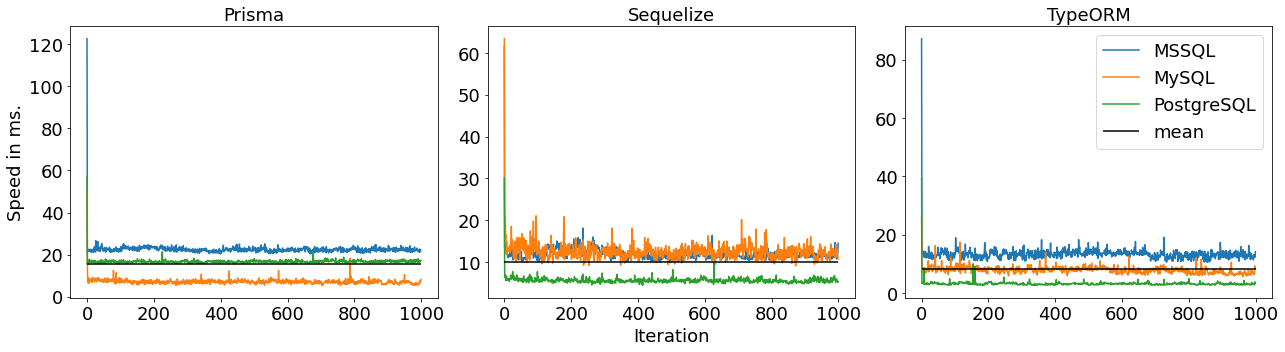

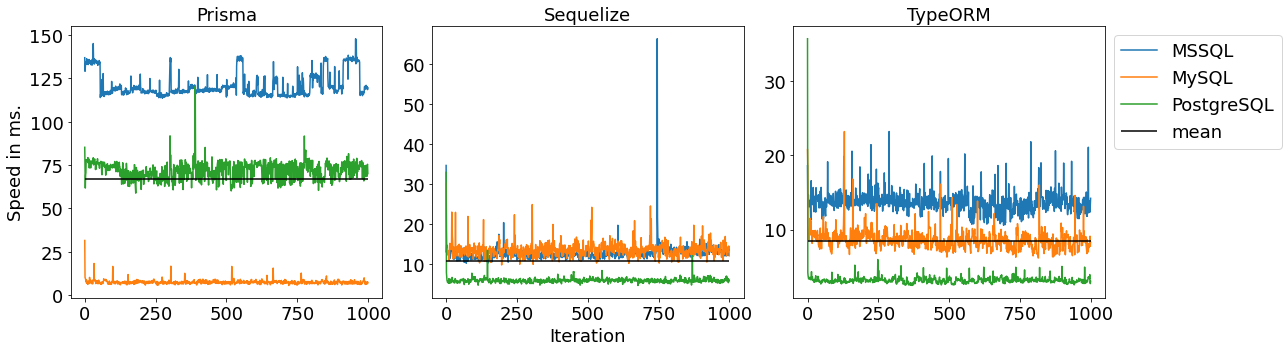

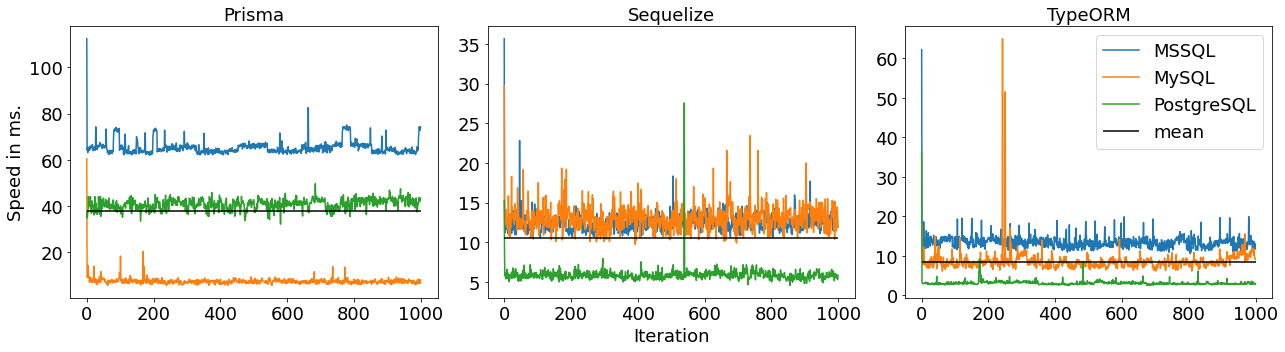

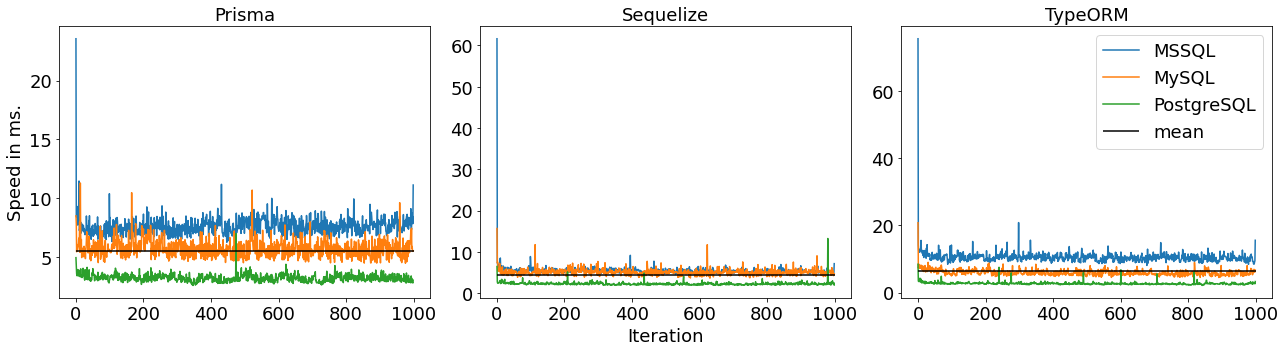

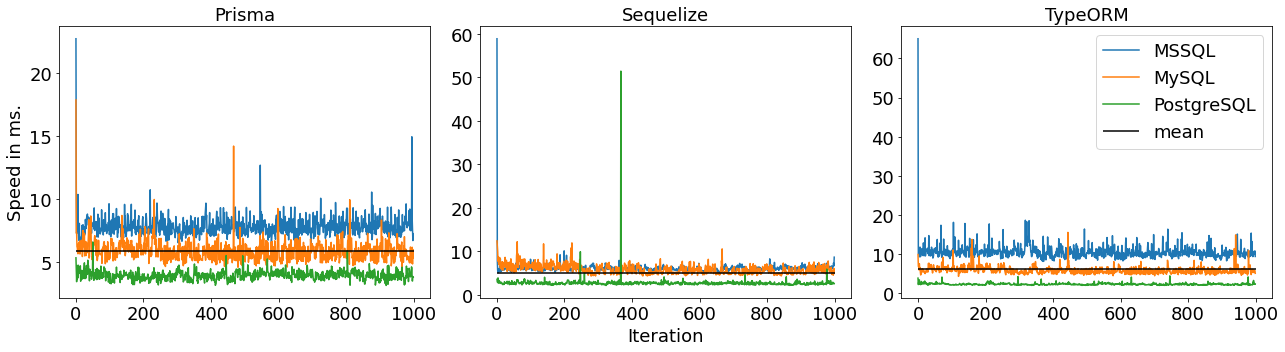

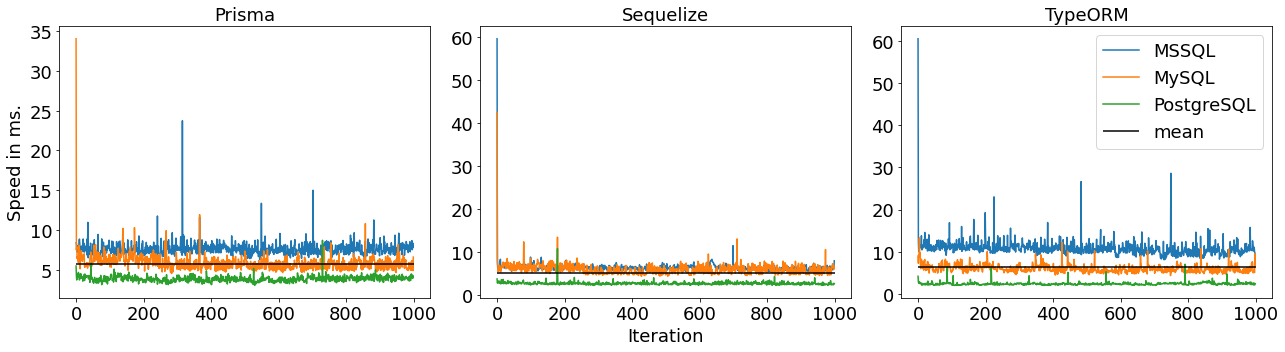

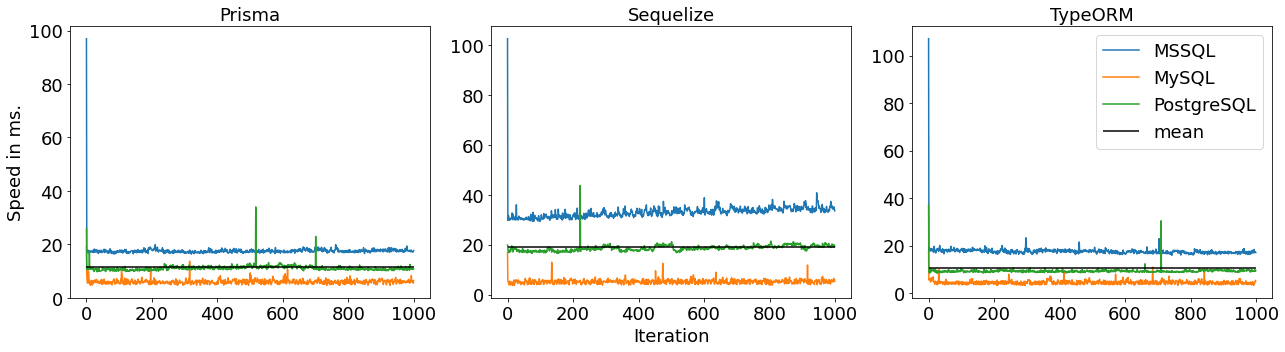

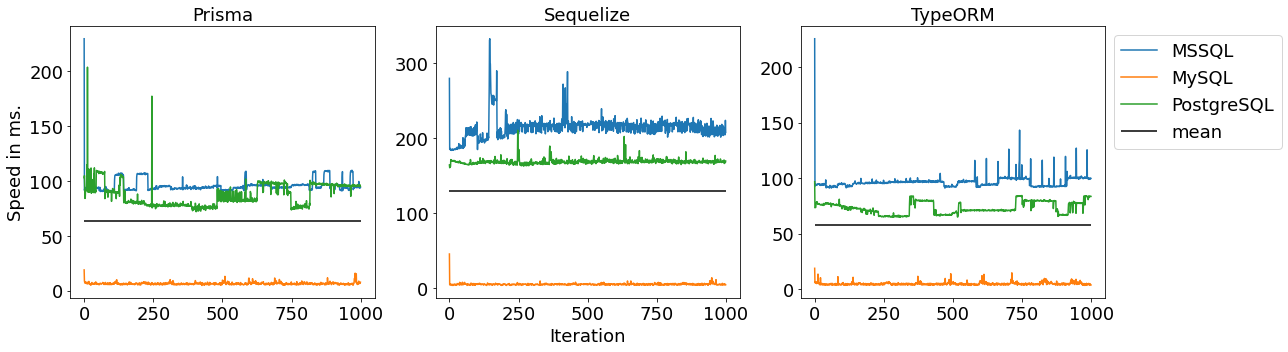

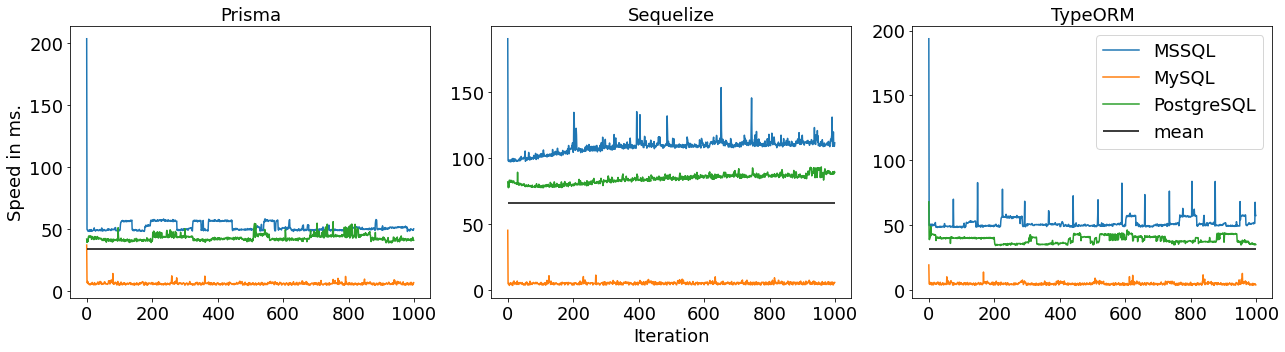

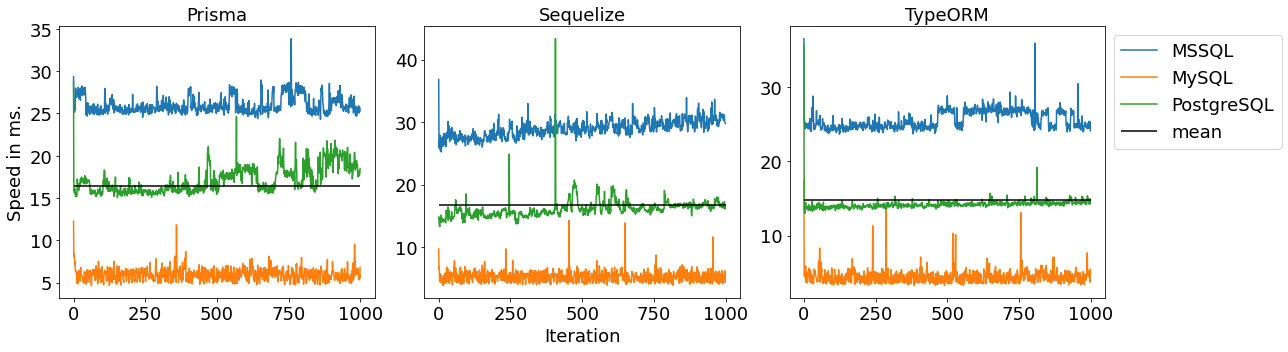

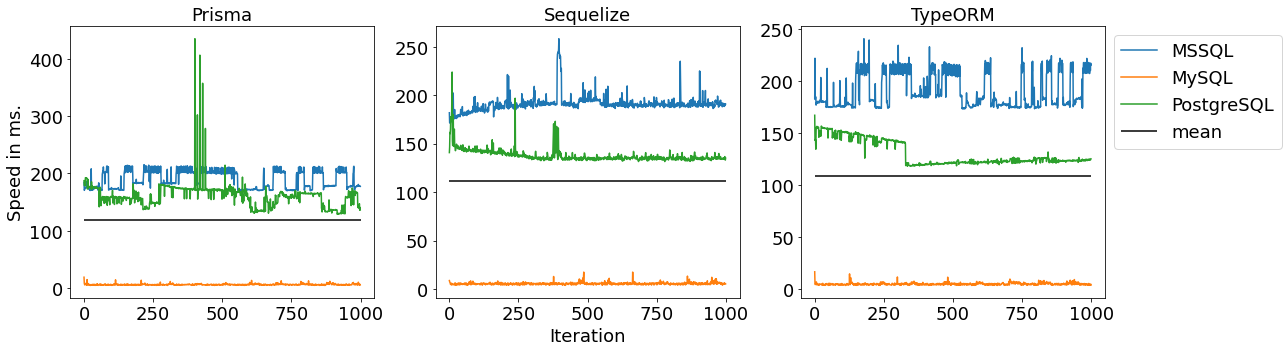

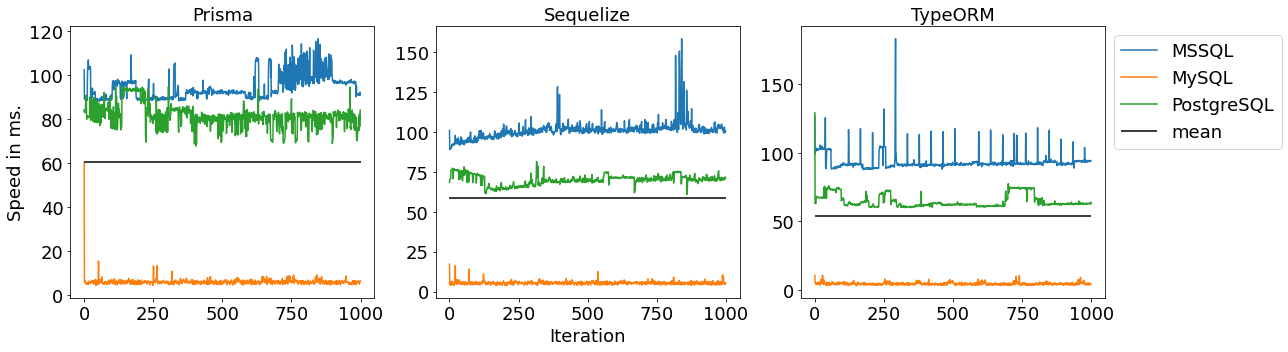

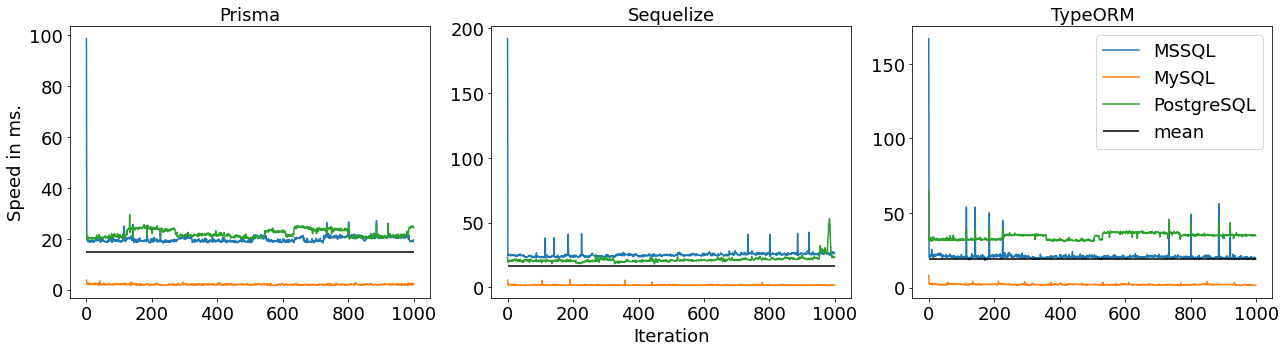

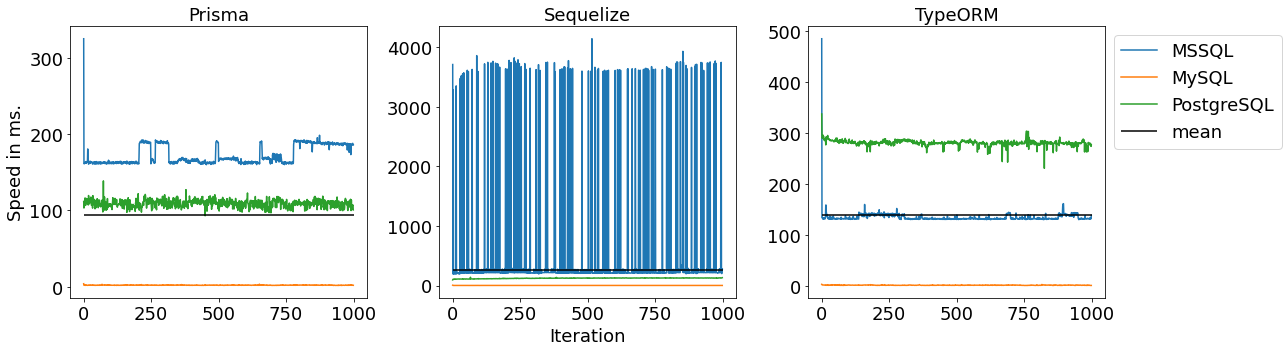

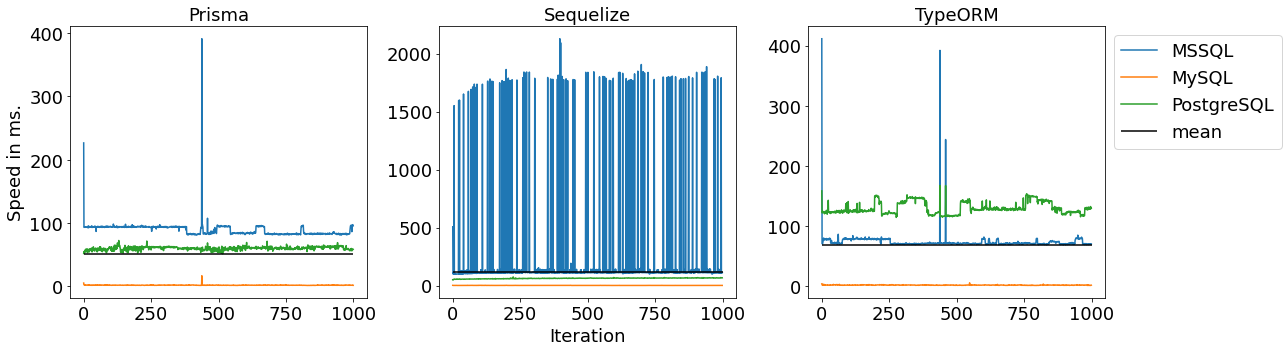

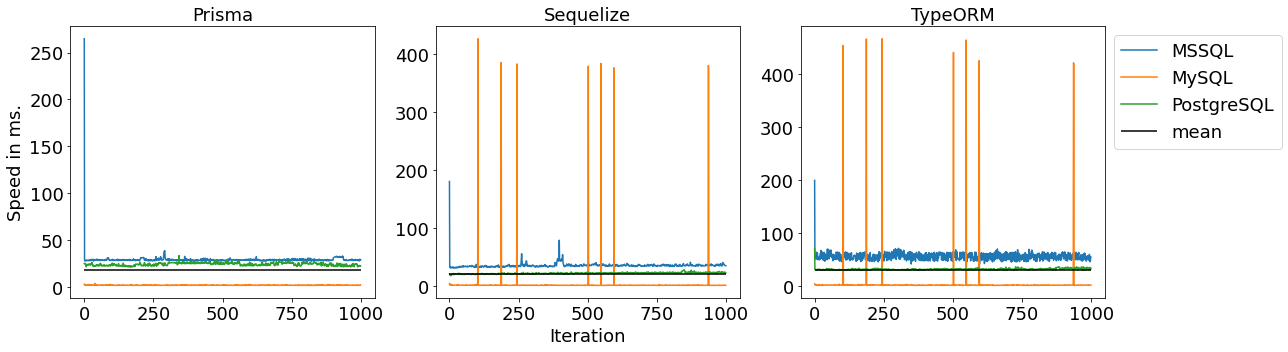

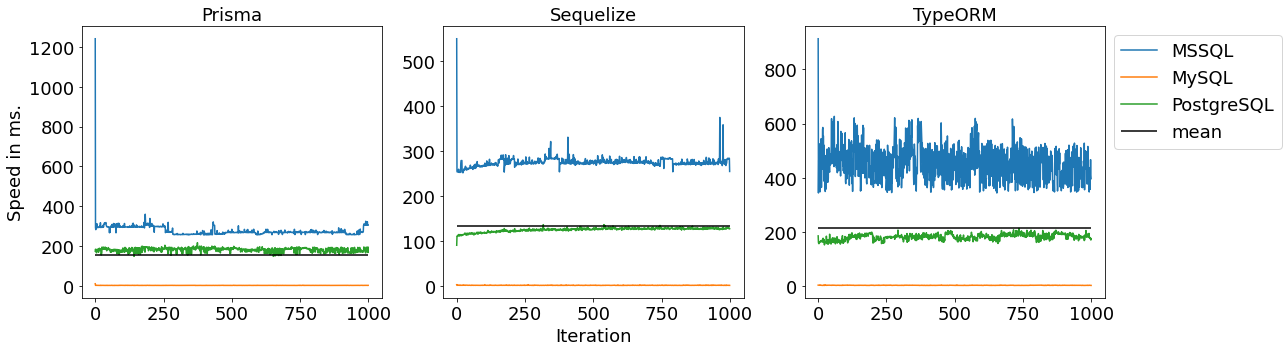

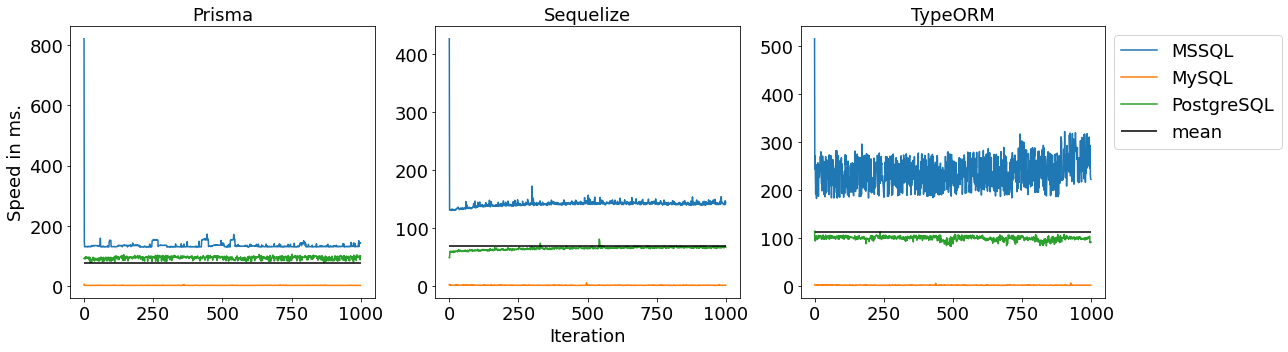

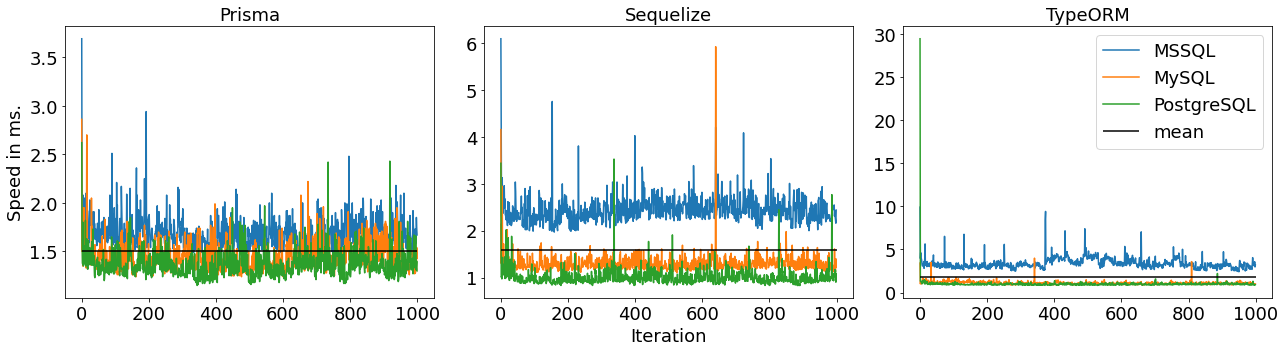

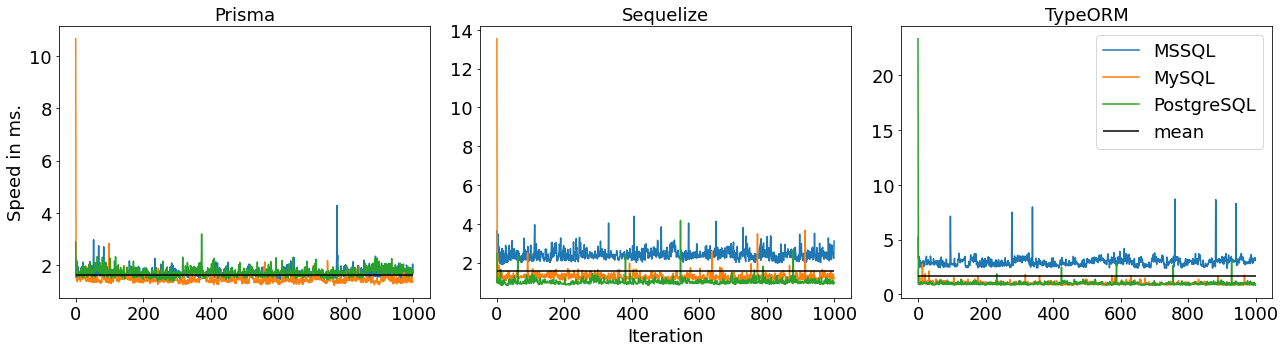

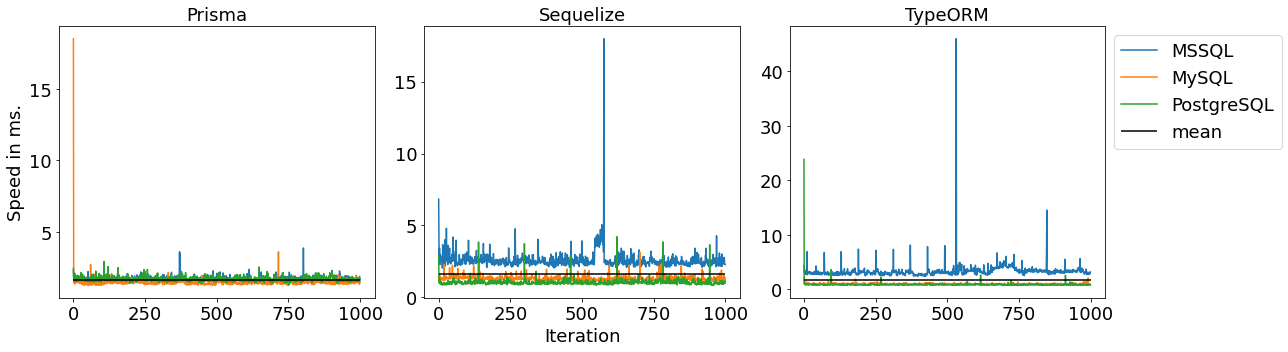

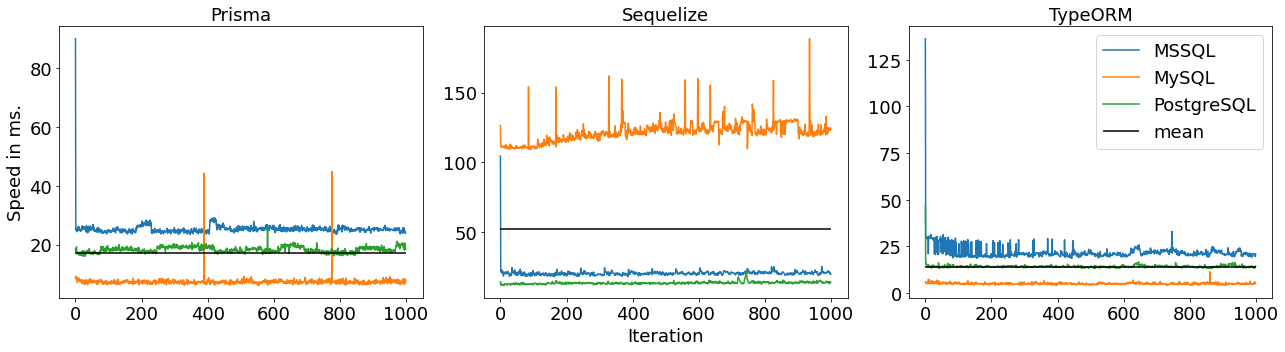

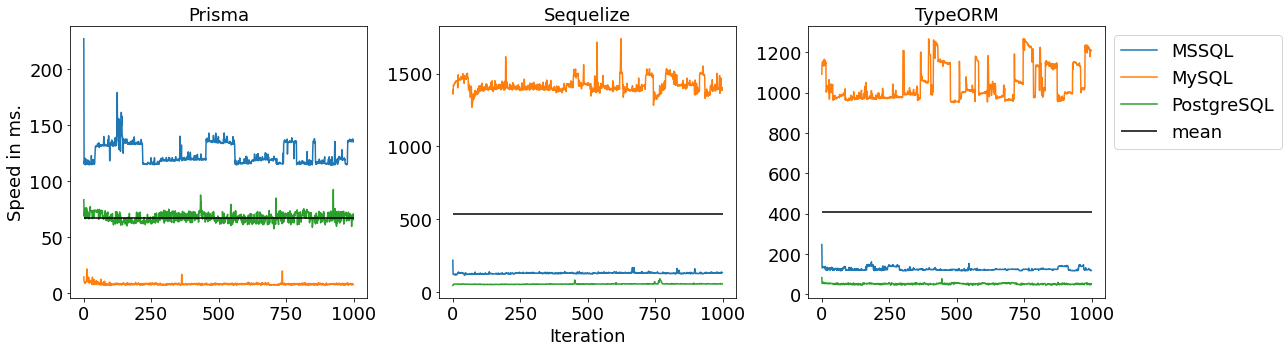

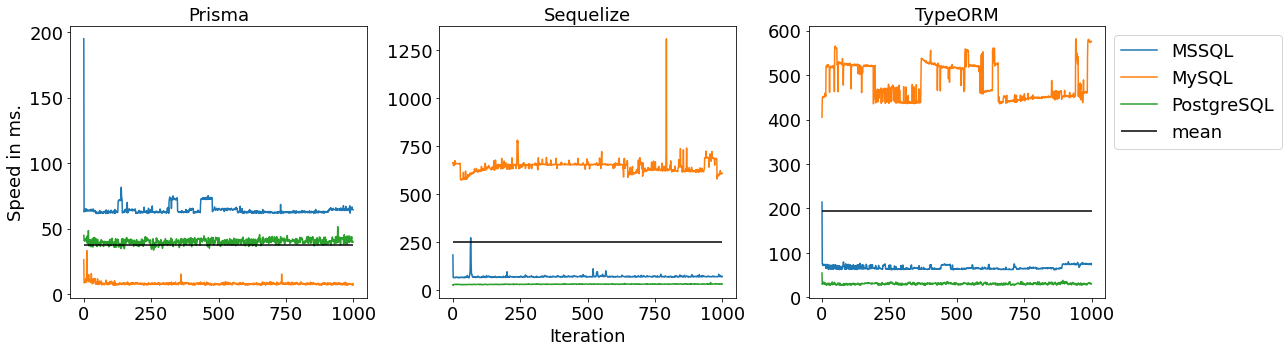

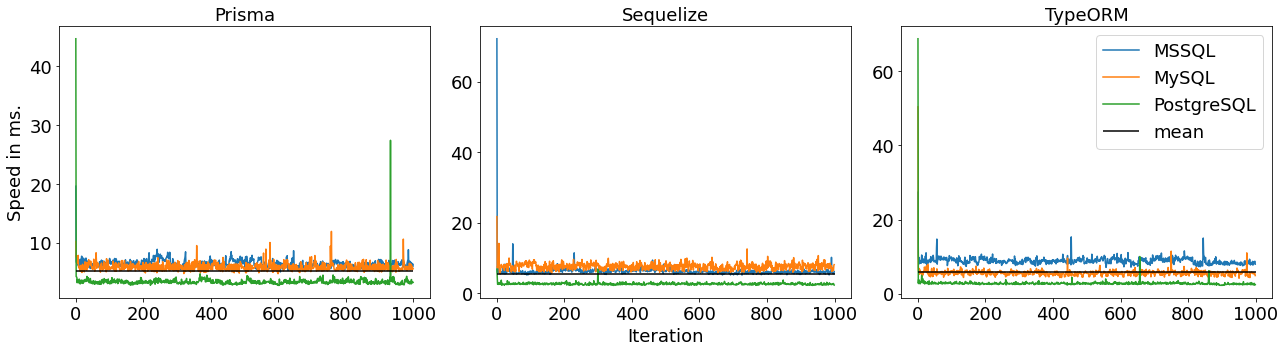

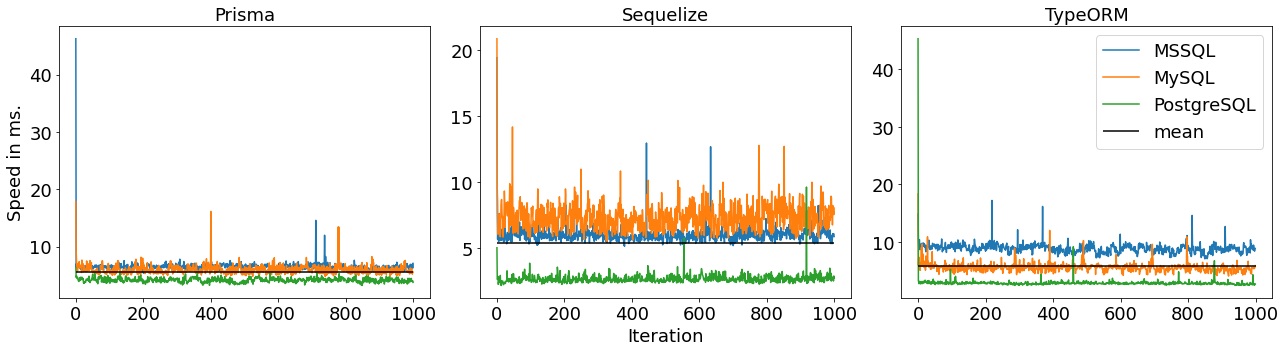

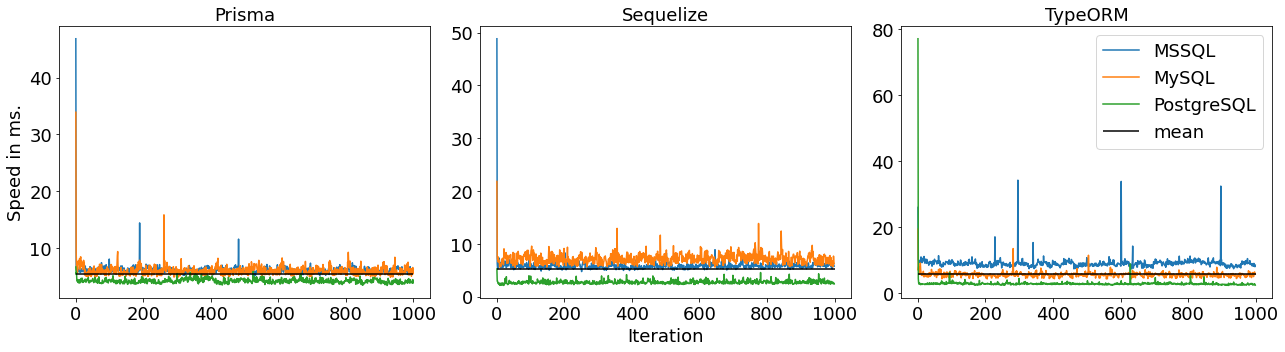

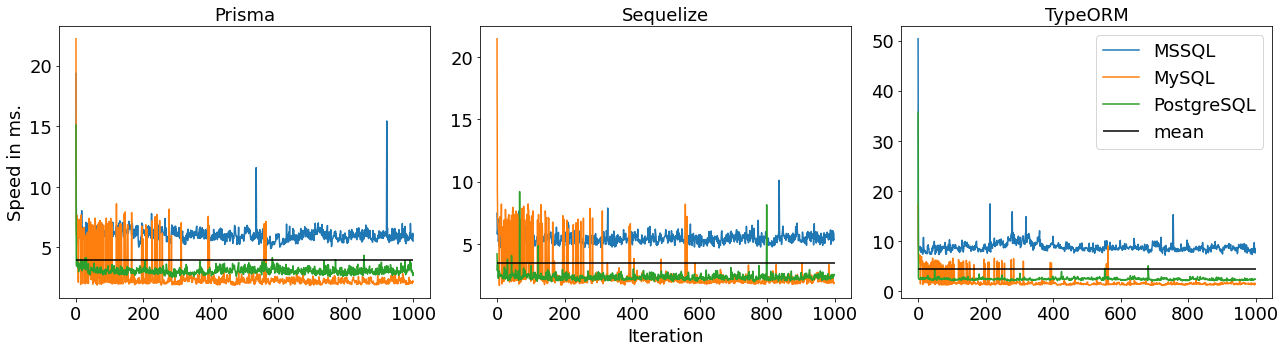

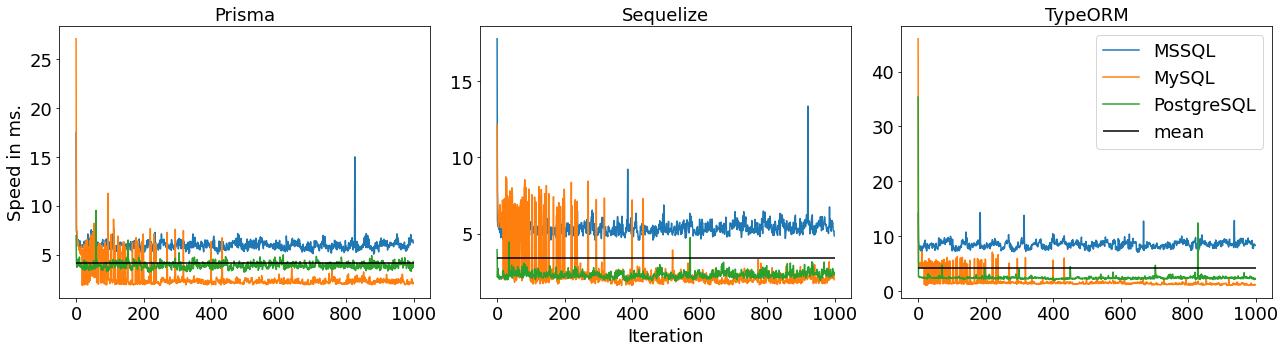

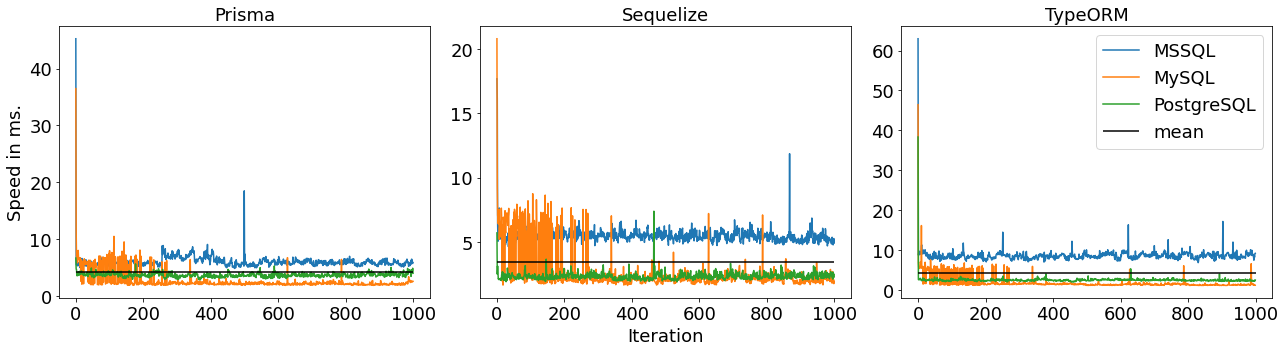

In [27]:
converter.create_charts()

In [28]:
table_file.close()